# Título Placeholder

## Preparar ambiente

In [1]:
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt

## Dados do Sistema e Constantes

In [2]:
# Tempo em minutos, de acordo com seção 3.3.2. (FABRICAÇÃO DO PRODUTO)
t_total = 60
# Massa de água e mosto, em kg, baseado na seção 3.3.2. (FABRICAÇÃO DO PRODUTO)
massa_agua = 25.5
massa_malte = 8.5
massa_mosto = massa_agua + massa_malte
# Aproximado da capacidade térmica da água em KJ/(kg·K), baseado em https://www.fq.pt/tabelas/capacidades-termicas-massicas . O mosto é uma mistura, eu estou usando o calor específico da água como aproximação.
c = 4.1855
""" # Constantes da equação de Antoine para a água de acordo com http://paginapessoal.utfpr.edu.br/lisandra/fisico-quimica-alimentos/anexos/C8-6_-_Pv_Antoine.pdf/view
ant_A = 18.3036
ant_B = 3816.44
ant_C = -46.13 """

""" # A constante universal dos gases perfeitos, valor em J mol^-1 K^-1, de acordo com https://physics.nist.gov/cgi-bin/cuu/Value?r , CODATA
R = 8.31446261 """

# Limites baseados nas restrições para a aplicação da Lei de Atoine de acordo com http://paginapessoal.utfpr.edu.br/lisandra/fisico-quimica-alimentos/anexos/C8-6_-_Pv_Antoine.pdf/view
# 284 e 441 Em Kelvin
# Limites reavaliados já que os dados relacinados à equação de Arrhenius forão testados entre 363.15 e 403.15 k (90 C° e 130 C°)
limites_temperatura = [(363.15, 441)]
T_min, T_max = limites_temperatura[0]


# 293.15 k é equivalente a 20 C°, eu achei que seria um valor inicial adequado
T0 = 293.15

""" # Massa molar da água de acordo com https://webbook.nist.gov/cgi/cbook.cgi?ID=C7732185&Mask=200
# Por enquanto, estou usando a massa molar da água, por que o mosto é uma mistura e, nesse caso, é composto, em grande parte, feito de água, mas eu posso levar em conta outras substências, como açúcar
massa_molar = 18.0153 """

# Potêcia da fonte de calor em kw, de acordo com (3.3.1) ESTRUTURA DA PLANTA PILOTO)
potencia = 6


# Funções Físico-Químicas e Funções Objetivos da Otimização

## Funções Físico-Químicas

In [3]:
def isomerizacao(T):
    # "Velocidade da isomerização"
    # A constante de Arrhenius para esse caso seria k = (7.9 × 10^11) e^(-11858/T), on T é a Temperatura Absoluta, baseado em https://doi.org/10.1021/jf0481296
    return 7.9e11 * np.exp(-11858 / T)

""" def pressao_vapor(T):
    T_celsius = T - 273.15
    # P, o valor sendo retornado, fica em mmHg
    return 10 ** (ant_A - ant_B / (ant_C + T_celsius))

def quantidade_materia():
    # formula baseada em https://chem.libretexts.org/Bookshelves/Introductory_Chemistry/Chemistry_for_Changing_Times_(Hill_and_McCreary)/05%3A_Chemical_Accounting/5.04%3A_Molar_Mass-_Mole-to-Mass_and_Mass-to-Mole_Conversions
    # usando massa da água por enquanto, já que eu estou usando a massa molar da água
    return massa_agua/massa_molar

def densidade_vapor(P,T):
    n = quantidade_materia()
    volume = (n*R*T)/P """

def energia_fornecida_func():
    # TODO: Pesquisar eficiência térmica de uma resistência elétrica submersa, por enquanto eu estou assumindo eficiência completa
    # formula baseado em https://phys.libretexts.org/Bookshelves/University_Physics/University_Physics_(OpenStax)/University_Physics_II_-_Thermodynamics_Electricity_and_Magnetism_(OpenStax)/09%3A_Current_and_Resistance/9.06%3A_Electrical_Energy_and_Power
    return potencia * t_total * 60 * 0.001 # potencia está em kW

def energia_usada_func(delta_T):
    return c * massa_mosto * delta_T


## Funções Objetivos da Otimização

In [13]:
# função 01
def energia_termica_total(T):
    # T = np.clip(T, T_min, T_max) # nao precisa definir aqui, está informação já se encontra em bounds na otimização
    # T = np.insert(T, 0, T0) # nao precisa definir aqui, está informação já se encontra em constraint na otimização
    # As diferenças entre as temperaturas do vetor
    delta_T = np.diff(T)
    return np.sum(delta_T * massa_mosto * c) # não tenho certeza se seria massa_mosto e c, por favor conferir


# função 02
def massa_evaporada_func(T):
    delta_T = np.diff(T)
    energia_fornecida = energia_fornecida_func()
    energia_usada = energia_usada_func(delta_T)
    energia_restante = energia_fornecida - energia_usada
    # TODO: implementar uma fórmula para entalpia específica de vaporização da água baseada na temperatura
    # a entalpia específica de vaporização da água varia com a temperatura, por enquanto eu estou o usando o valor para água a 100 C°, em kj/kg. Baseado em https://en.wikipedia.org/wiki/Enthalpy_of_vaporization
    h = 2257
    return np.sum(energia_restante)/h # deve-se retornar um escalar


# função 03
def iso_total_func():
    return 0.0


# função 04
def densidade_func():
    # massa_restante = massa_mosto - massa_evaporada
    #TODO: Entender como medir o volume
    return 0.0

# Função Objetivo Total

A entrada de temperatura (ou seja, os valores de T) precisa ter espaços de tempo equivalentes.

In [15]:
def func_objetivo(T):

    energia_total = energia_termica_total(T) # funções objetivas devem retorna um escalar
    
    massa_evaporada = massa_evaporada_func(T)

    iso_total = iso_total_func() # TODO

    densidade = densidade_func() # TODO

    # Pesos, de acordo com o objetivo (Minimizar energia e evaporação, maximizar isomerização e regular a densidade), seção 3.3.3.(CONTROLE ÓTIMO MULTIOBJETIVO UTILIZANDO ALGORITMO GENÉTICO)
    w1, w2, w3, w4 = 1, -1, 1, -1

    return (
        w1 * energia_total +
        w2 * iso_total +
        w3 * massa_evaporada +
        w4 * densidade
    )

In [16]:
# vetor de tempo
N = 100
t_array = np.linspace(0, t_total, N)

# chute inicial para a otimização
perfil_temperatura_inicial = T0 * np.ones(N) 

# bounds para q_entrada
perfil_temperatura_limites = limites_temperatura

# Define constraint dictionary
def eq_constraint_initial_temprature(T):
    return T[0]  - T0

con = {'type': 'eq', 'fun': eq_constraint_initial_temprature}

In [17]:
res = minimize(func_objetivo, 
               perfil_temperatura_inicial, 
               bounds=perfil_temperatura_limites,
               constraints=con)

print("Resultado da otimização:")
print("Calor aplicado:", res.x[0])
print("Valor da função objetivo:", res.fun)

Resultado da otimização:
Calor aplicado: 363.15
Valor da função objetivo: 0.9474523704031901


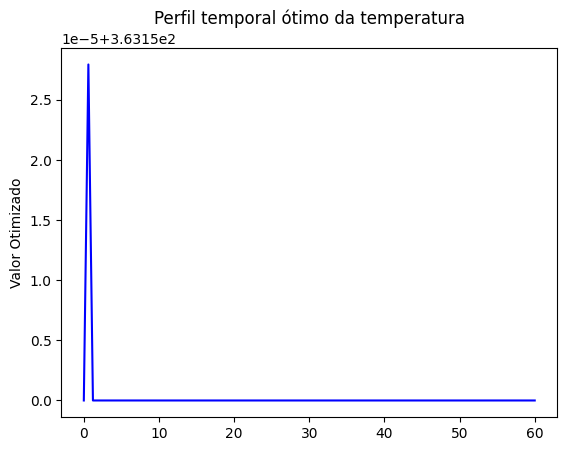

In [19]:
plt.plot(t_array, res.x, color='blue')
plt.ylabel('Valor Otimizado')
plt.title('Perfil temporal ótimo da temperatura')
plt.show()